##### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2025 Semester 1

## Assignment 1: Scam detection with naive Bayes


**Student ID(s):**     `1409447`


This iPython notebook is a template which you will use for your Assignment 1 submission.

**NOTE: YOU SHOULD ADD YOUR RESULTS, GRAPHS, AND FIGURES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).** Results, figures, etc. which appear in this file but are NOT included in your report will not be marked.

**Adding proper comments to your code is MANDATORY. **

## 1. Supervised model training


In [19]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Load data from sms_supervised_train.csv
supervised_df = pd.read_csv('COMP30027_2025_asst1_data/sms_supervised_train.csv')

# Drop instances with missing values in both 'textPreprocessed' and 'class' columns
supervised_df = supervised_df.dropna(subset=['textPreprocessed', 'class'])

# Reset index after dropping rows (to ensure indices align correctly) -- or else indices mess up and NaN vals appear
supervised_df.reset_index(drop=True, inplace=True)

# Vectorize as a bag-of-words model -- ignore multiple spaces
v = CountVectorizer(token_pattern=r'[^\s]+')

# Transform the text data into bag-of-words
x = v.fit_transform(supervised_df['textPreprocessed'])

# Get all unique words
words = v.get_feature_names_out()

# Generate dataframe using the bag-of-word vectors
word_df = pd.DataFrame(x.toarray(), columns=words)

# Reset the index of word_df in case it has been modified during vectorization
word_df.reset_index(drop=True, inplace=True)

# Align the class labels
word_df['ScamClassLabel'] = supervised_df['class'].values

# Check the unique values in 'ScamClassLabel'
print(word_df['ScamClassLabel'].unique()) # SHOULD BE [0 1]

print(word_df.shape) # SHOULD BE (1995, 2007 (2006 + class label))
print(len(words))

[0 1]
(1995, 2007)
2006


In [20]:
# 3 : Calculate the prior probability for each class (scam=1, not scam=0), which is N_c / N

N = word_df.shape[0]

# Prior probability for non-malicious,ScamClassLabel = 0
word_df[word_df["ScamClassLabel"] == 0].head(10)

N_non_malicious = word_df[word_df["ScamClassLabel"] == 0].shape[0]

# Prior probability for malicious, ScamClassLabel = 1
word_df[word_df["ScamClassLabel"] == 1].head(10)

N_scam = word_df[word_df["ScamClassLabel"] == 1].shape[0]

assert(N_scam + N_non_malicious == N)

# Prior for non-malicious
prior_non_malicious = N_non_malicious / N

# Prior for scam
prior_scam = N_scam / N

# Part 1, Q1
print(prior_non_malicious)
print(prior_scam)

0.7994987468671679
0.20050125313283207


In [21]:
# 4 

# Steps: for two dataframes (scam and non-malicious), do:
    # Get total count for each word (column sum)
    # Get total count of all words (table sum)
    # Create a dictionary to store (word : probability)
    # with probability = column sum / table sum
    
    # TODO : decide on Laplace smoothing params and ensure sum of probs = 1
    
from sklearn.naive_bayes import MultinomialNB
import numpy as np


# Get counts for all features except class label
word_counts = word_df.drop('ScamClassLabel', axis=1) 

scam_label = word_df['ScamClassLabel']

model = MultinomialNB() # Uses laplace smoothing with alpha = 1 by default
model.fit(word_counts, scam_label)

scam_log_probs = model.feature_log_prob_[1]
scam_probs = [np.exp(prob) for prob in scam_log_probs]

assert(abs(sum(scam_probs) - 1) < 0.000001)
# Now, associate each probability to the matching word. Note: feature_log_prob returns probabilities in the same order
scam_word_probs = list(zip(words, scam_probs)) 
# Then, sort by probability in descending order
scam_word_probs.sort(key=lambda x: x[1], reverse=True)

# Part 1 Q2
print(f'Top 10 malicious words are: {scam_word_probs[:10]}')

# Similar process here for non-malicious words
non_scam_log_probs = model.feature_log_prob_[0]
non_scam_probs = [np.exp(prob) for prob in non_scam_log_probs]
assert(abs(sum(non_scam_probs) - 1) < 0.000001)
# Now, associate each probability to the matching word. Note: feature_log_prob returns probabilities in the same order
non_scam_word_probs = list(zip(words, non_scam_probs)) 
# Then, sort by probability in descending order
non_scam_word_probs.sort(key=lambda x: x[1], reverse=True)

# Part 1 Q2
print(f'Top 10 non-malicious words are: {non_scam_word_probs[:10]}')




Top 10 malicious words are: [('.', 0.056527883465594106), ('!', 0.024350472877486685), (',', 0.023480813131862177), ('call', 0.0205457114903794), ('£', 0.013914555929992392), ('free', 0.010544624415697363), ('/', 0.009131427329057508), ('2', 0.008805304924448316), ('&', 0.008696597456245245), ('?', 0.008479182519839116)]
Top 10 non-malicious words are: [('.', 0.07933042212518195), (',', 0.026032919046019464), ('?', 0.025585040868883666), ('u', 0.018922852983988353), ('...', 0.018754898667562414), ('!', 0.017187325047587045), ('..', 0.014947934161907959), (';', 0.01315642145336468), ('&', 0.013100436681222707), ('go', 0.011140969656253495)]


In [22]:
# Part 1 Q3

# Convert each list into dicts, with word:prob
# Create R score dict FOR scam/nonscam and nonscam/scam
# For each, word : probc1/probc2, c1 and c2 are the classes


scam_prob_dict = dict(scam_word_probs)
non_scam_prob_dict = dict(non_scam_word_probs)

R_scam = {word: scam_prob_dict[word]/non_scam_prob_dict[word] for word in scam_prob_dict.keys()}
R_non_scam = {word: non_scam_prob_dict[word]/scam_prob_dict[word] for word in non_scam_prob_dict.keys()}

# Convert back to list and sort by R score -- note that these are probability ratios, not probabilities
R_scam_scores = sorted(list(R_scam.items()), key=lambda x: x[1], reverse=True)
print(f"Top 10 words likely to be scam than non-scam: {R_scam_scores[:10]}")

R_non_scam_scores = sorted(list(R_non_scam.items()), key=lambda x: x[1], reverse=True)
print(f"Top 10 words likely to be non-scam than scam: {R_non_scam_scores[:10]}")


Top 10 words likely to be scam than non-scam: [('prize', 99.0283726492011), ('tone', 64.07718230242419), ('£', 49.708359604304874), ('select', 46.601587129035785), ('claim', 45.954342863354775), ('paytm', 36.89292314382), ('code', 34.95119034677684), ('award', 32.03859115121209), ('won', 31.06772475269054), ('18', 29.125991955647386)]
Top 10 words likely to be non-scam than scam: [(';', 60.51296047475082), ('...', 57.508770947635554), ('gt', 54.07541148807519), ('lt', 53.56040756914115), (':)', 47.89536446086663), ('ü', 31.93024297391108), ('lor', 28.840219460306788), ('ok', 24.720188108834375), ('hope', 24.720188108834375), ('d', 21.115160676296036)]


## 2. Supervised model evaluation

In [23]:
from sklearn.metrics import accuracy_score
import pandas as pd

# Similar to part 1, initialize word matrix BUT dont need to add class labels -- same order
test_df = pd.read_csv('COMP30027_2025_asst1_data/sms_test.csv')

# Drop instances with missing values in both 'textPreprocessed' and 'class' columns
test_df = test_df.dropna(subset=['textPreprocessed', 'class'])

# Reset index after dropping rows (to ensure indices align correctly) -- or else indices mess up and NaN vals appear
test_df.reset_index(drop=True, inplace=True)

# Create a CountVectorizer with the same vocabulary as in part 1
vectorizer = CountVectorizer(vocabulary=words, token_pattern=r'[^\s]+')

# Vectorize data
test_data = vectorizer.transform(test_df["textPreprocessed"]) 

# Convert to df with columns being the same as the original words trained on
supervised_test = pd.DataFrame.sparse.from_spmatrix(test_data, columns=vectorizer.get_feature_names_out())

# Make predictions
pred = model.predict(supervised_test)

# Calculate and print accuracy
print(f"{accuracy_score(test_df['class'], pred) * 100:.2f}%")

# Count OOV words
oov_count = {}
for text in test_df["textPreprocessed"]:
    for word in str(text).split():
        if word not in words:
            oov_count[word] = oov_count.get(word, 0) + 1
            
print(supervised_test.shape)

97.50%
(1000, 2006)


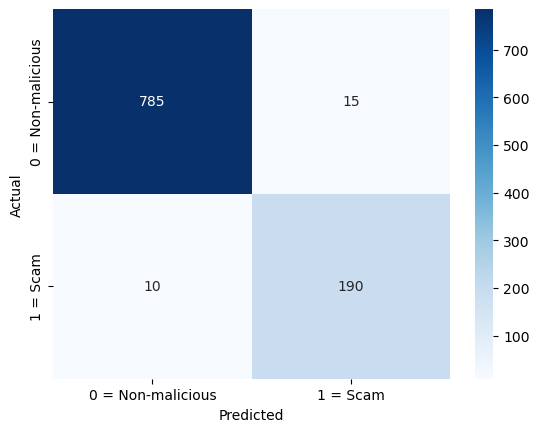

Precision : 92.68%
Recall : 95.00%
Number of OOV words skipped is 179


In [24]:
# Now to plot confusion matrix, show recall and precision
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Use sklearn to get confusion matrix values from predictor
conf_matrix = confusion_matrix(test_df['class'], pred)

# Plot using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0 = Non-malicious', '1 = Scam'], 
            yticklabels=['0 = Non-malicious', '1 = Scam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

print(f"Precision : {precision_score(test_df['class'], pred) * 100:.2f}%")
print(f"Recall : {recall_score(test_df['class'], pred) * 100:.2f}%")

base_accuracy = accuracy_score(test_df['class'], pred)
base_precision = precision_score(test_df['class'], pred)
base_recall = recall_score(test_df['class'], pred)


# Part 2 Q2

print(f"Number of OOV words skipped is {sum(oov_count.values())}")
# Quite many words were skipped



In [25]:
# Part 2 Q3
from pprint import pprint
# First get predicted class probabilities for each instance
predicted_probs = model.predict_proba(supervised_test)
print(model.classes_)
print(predicted_probs[:10])

instance_probs = []  # First element is instance, second is prob of 0(nonscam), third is prob of 1(scam)
instance_confidence = [] # First element is instance, second is confidence for non-malicious, third for scam, fourth is original text
for i in range(len(predicted_probs)):
    instance = test_df['textPreprocessed'].loc[i]
    instance_probs.append([instance, *(predicted_probs[i].tolist())])
    real_text = test_df['textOriginal'].loc[i]
    
    # index 0 = prob of non scam, 1 = prob of scam, both given the test instance
    non_scam_confidence = predicted_probs[i][0] / predicted_probs[i][1]
    scam_confidence = predicted_probs[i][1] / predicted_probs[i][0]
    
    instance_confidence.append([instance, non_scam_confidence, scam_confidence, real_text])
    

# A : classified scam with high confidence -- element 3
print("Top 5 most confident to be scams as classified by model")
pprint([[f"REAL: {instance[3]}", f"PREP: {instance[0]}"] for instance in sorted(instance_confidence, key=lambda x: x[2], reverse=True)[:5]], compact=False, indent=2)

print("Top 5 most confident to be non-scams as classified by model")
# B : classified non-malicious with high confidence -- element 2
pprint([[f"REAL: {instance[3]}", f"PREP: {instance[0]}"] for instance in sorted(instance_confidence, key=lambda x: x[1], reverse=True)[:5]], compact=False, indent=2)

# C : on the boundary, R near 1.
bound_width = 0.25
print("Boundary instances")
for i in instance_confidence:
    # If R score for scam and nonscam are similar, theyre close to 1
    if abs(i[1] - i[2]) < bound_width:
        print(f"R-non-scam = {i[1]}, R-scam = {i[2]}")
        print(f"REAL: {i[3]}")
        print(f"PREP: {i[0]}")
        print()

[0 1]
[[9.99802906e-01 1.97094426e-04]
 [9.99999405e-01 5.94851453e-07]
 [9.99914145e-01 8.58549033e-05]
 [9.99999967e-01 3.30104973e-08]
 [3.27228433e-08 9.99999967e-01]
 [1.00000000e+00 6.62774452e-14]
 [8.54892539e-01 1.45107461e-01]
 [9.93768132e-01 6.23186845e-03]
 [9.99443233e-01 5.56766595e-04]
 [9.99999933e-01 6.71365781e-08]]
Top 5 most confident to be scams as classified by model
[ [ 'REAL: Urgent -call 09066649731from Landline. Your complimentary 4* Ibiza '
    'Holiday or £10,000 cash await collection SAE T&Cs PO BOX 434 SK3 8WP '
    '150ppm 18+',
    'PREP: . 4 + call £ - * holiday & urgent 18 t landline 150ppm cash cs '
    'await collection po box sae complimentary 10,000 ibiza'],
  [ 'REAL: Urgent! call 09066612661 from landline. Your complementary 4* '
    'Tenerife Holiday or £10,000 cash await collection SAE T&Cs PO Box 3 WA14 '
    '2PX 150ppm 18+ Sender: Hol Offer',
    'PREP: . 3 4 + ! call : £ offer * holiday & urgent 18 t landline 150ppm '
    'cash cs await co

## 3. Extending the model with semi-supervised training

In [26]:
# First, split the original training data into train-validation splits of ratio 80:20
from sklearn.model_selection import train_test_split

train_df, valid_df, train_y, valid_y = train_test_split(word_df.drop('ScamClassLabel', axis=1), word_df['ScamClassLabel'], test_size=0.2,
                                                        random_state=42)

print(train_df.shape)
print(train_y.shape)
print(valid_df.shape)
print(valid_y.shape)

# Now train
split_model = MultinomialNB()
split_model.fit(train_df, train_y)

# Add labels to the end of the dataframes
train_df['ScamClassLabel'] = train_y
valid_df['ScamClassLabel'] = valid_y

(1596, 2006)
(1596,)
(399, 2006)
(399,)


In [36]:
# Calculate the new base accuracy, precision and recall by testing model on validation set
pred_v = split_model.predict(valid_df.drop('ScamClassLabel', axis=1))
base_accuracy = accuracy_score(valid_df['ScamClassLabel'], pred_v)
base_precision = precision_score(valid_df['ScamClassLabel'], pred_v)
base_recall = recall_score(valid_df['ScamClassLabel'], pred_v)

print(base_accuracy, base_precision, base_recall)

0.9624060150375939 0.85 0.9577464788732394


In [27]:
# Almost exactly the same code as part 2

# Similar to part 1, initialize word matrix BUT dont need to add class labels -- same order
unsup_df = pd.read_csv('COMP30027_2025_asst1_data/sms_unlabelled.csv')

# Drop instances with missing values in both 'textPreprocessed' and 'class' columns
unsup_df = unsup_df.dropna(subset=['textPreprocessed', 'class'])

# Reset index after dropping rows (to ensure indices align correctly) -- or else indices mess up and NaN vals appear
unsup_df.reset_index(drop=True, inplace=True)

# Create a CountVectorizer with the same vocabulary as in part 1
vectorizer = CountVectorizer(vocabulary=words, token_pattern=r'[^\s]+')

# Vectorize data
unsup_data = vectorizer.transform(unsup_df["textPreprocessed"]) 

# Convert to df with columns being the same as the original words trained on
unsup_test = pd.DataFrame.sparse.from_spmatrix(unsup_data, columns=vectorizer.get_feature_names_out())

# Make predictions
unsup_pred = split_model.predict(unsup_test)

In [28]:
# Now that we have the predicted labels, 
 
# Option A : retrain model with ALL of the unsupervised data
# First add the predictions as class labels to the dataframe

unlabelled_df = unsup_test.copy()
unlabelled_df['ScamClassLabel'] = unsup_pred

concat_df = pd.concat([train_df, unlabelled_df], ignore_index=True)

# Now train new model based on this

# Get counts for all features except class label
conc_word_counts = concat_df.drop('ScamClassLabel', axis=1) 

conc_scam_label = concat_df['ScamClassLabel']

concat_model = MultinomialNB() # Uses laplace smoothing with alpha = 1 by default
concat_model.fit(conc_word_counts, conc_scam_label)

MultinomialNB()

95.99%


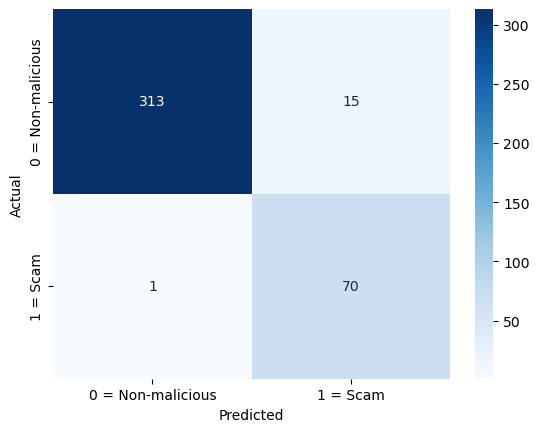

Precision : 82.35%
Recall : 98.59%


In [31]:
# Test performance on validation set 
# Make predictions
conc_pred = concat_model.predict(valid_df.drop('ScamClassLabel', axis=1))

# Calculate and print accuracy
print(f"{accuracy_score(valid_df['ScamClassLabel'], conc_pred) * 100:.2f}%")

# Show conf matrix
conf_matrix = confusion_matrix(valid_df['ScamClassLabel'], conc_pred)

# Plot using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0 = Non-malicious', '1 = Scam'], 
            yticklabels=['0 = Non-malicious', '1 = Scam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

print(f"Precision : {precision_score(valid_df['ScamClassLabel'], conc_pred) * 100:.2f}%")
print(f"Recall : {recall_score(valid_df['ScamClassLabel'], conc_pred) * 100:.2f}%")

In [32]:
# CHECKING PERFORMANCE FOR EACH CONFIDENCE BOUNDARY
# Get predicted probabilities for each instance
unsup_predicted_probs = model.predict_proba(unsup_test)

# Extract probabilities for both classes and calculate confidence ratios
non_scam_probs = unsup_predicted_probs[:, 0]
scam_probs = unsup_predicted_probs[:, 1]
non_scam_confidence = non_scam_probs / scam_probs
scam_confidence = scam_probs / non_scam_probs

# Create a dictionary mapping indices to all necessary information
# This avoids creating a large intermediate DataFrame
confidence_data = {
    'index': np.arange(len(unsup_predicted_probs)),
    'non_scam_confidence': non_scam_confidence,
    'scam_confidence': scam_confidence,
    'predicted_class_label': unsup_pred
}

# Prepare confidence boundaries as logarithmic scale
confidence_boundaries = np.logspace(-5, 25, num=30)

# Pre-allocate arrays for metrics
num_boundaries = len(confidence_boundaries)
accuracies = np.zeros(num_boundaries)
precisions = np.zeros(num_boundaries)
recalls = np.zeros(num_boundaries)

# Pre-compute values that don't change in the loop
supervised_test_X = valid_df.drop('ScamClassLabel', axis=1)
test_y = valid_df['ScamClassLabel']

# Get the original word counts and labels once
original_word_counts = train_df.drop('ScamClassLabel', axis=1)
original_labels = train_df['ScamClassLabel']

# Cache the unlabelled data features
unlabelled_features = unlabelled_df.drop('ScamClassLabel', axis=1) if 'ScamClassLabel' in unlabelled_df.columns else unlabelled_df

for i, confidence_boundary in enumerate(confidence_boundaries):
    # Get indices of high confidence predictions more efficiently
    high_conf_scam_indices = np.where(confidence_data['scam_confidence'] > confidence_boundary)[0]
    high_conf_non_scam_indices = np.where(confidence_data['non_scam_confidence'] > confidence_boundary)[0]
    high_conf_indices = np.concatenate([high_conf_scam_indices, high_conf_non_scam_indices])
    
    # Skip iteration if no high confidence predictions
    if len(high_conf_indices) == 0:
        accuracies[i] = accuracies[i-1] if i > 0 else 0
        precisions[i] = precisions[i-1] if i > 0 else 0
        recalls[i] = recalls[i-1] if i > 0 else 0
        continue
    
    # Get the corresponding unlabelled features and predicted labels
    highconf_features = unlabelled_features.iloc[high_conf_indices]
    highconf_labels = pd.Series(confidence_data['predicted_class_label'][high_conf_indices])
    
    # Instead of concatenating DataFrames, concatenate only the features and labels
    # This avoids creating multiple large intermediate DataFrames
    combined_features = pd.concat([original_word_counts, highconf_features])
    combined_labels = pd.concat([original_labels, highconf_labels])
    
    # Train the model
    concat_model = MultinomialNB()
    concat_model.fit(combined_features, combined_labels)
    
    # Make predictions
    conc_pred = concat_model.predict(supervised_test_X)
    
    # Calculate metrics
    accuracies[i] = accuracy_score(test_y, conc_pred)
    precisions[i] = precision_score(test_y, conc_pred)
    recalls[i] = recall_score(test_y, conc_pred)


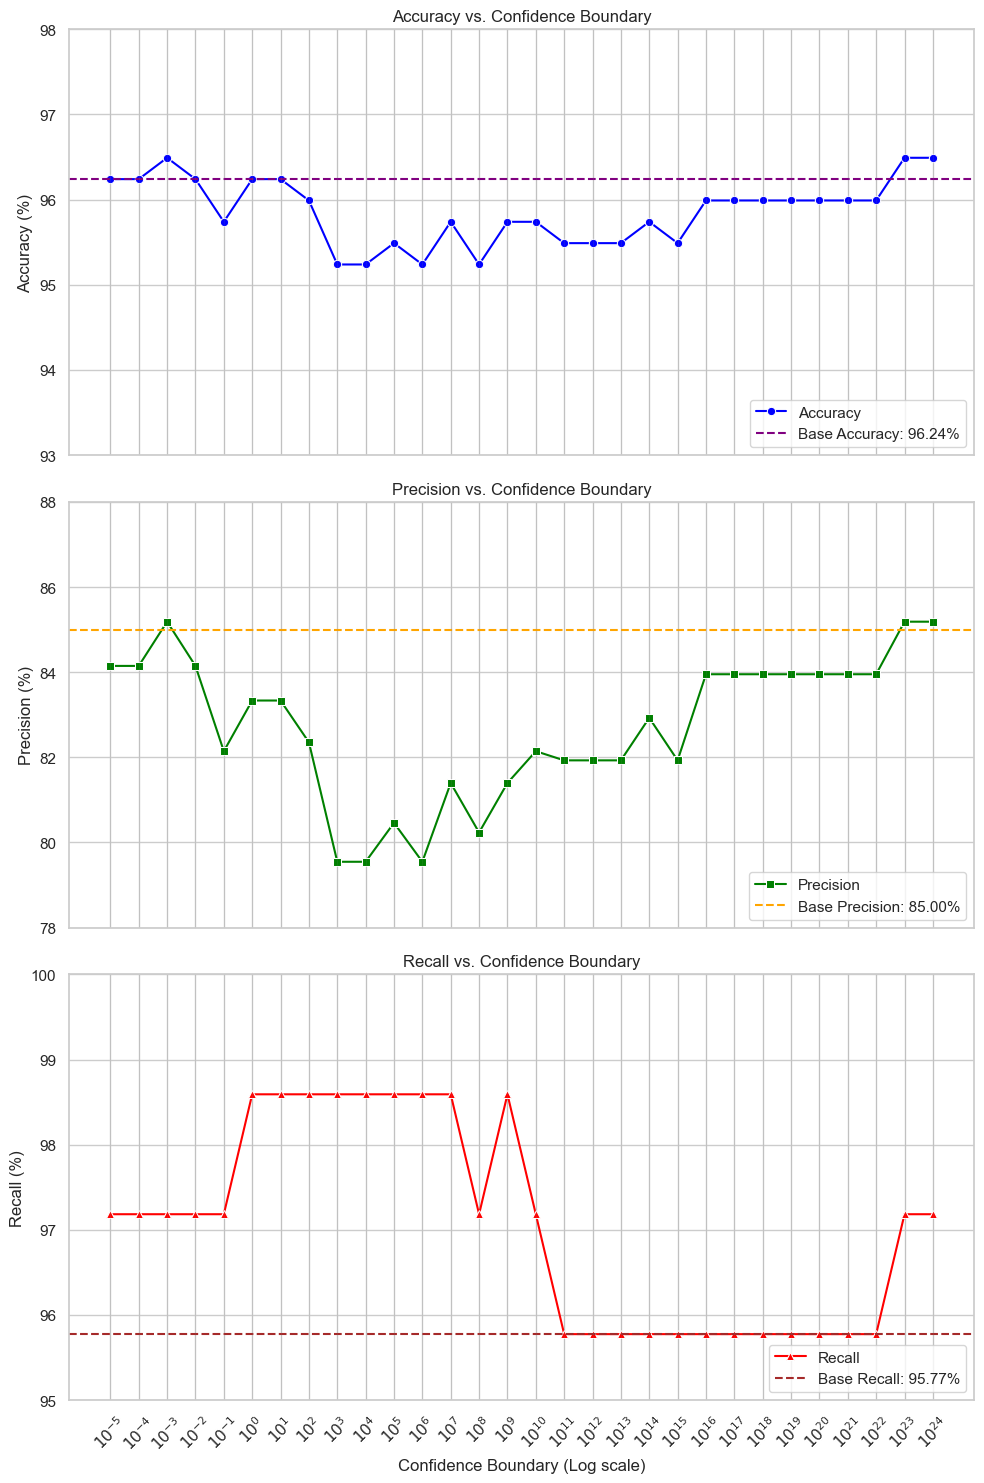

Max Accuracy: 96.49% at confidence boundary 1.2e-03
Max Precision: 85.19% at confidence boundary 1.2e-03
Max Recall: 98.59% at confidence boundary 1.5e+00


In [52]:
# Set the Seaborn style
sns.set_theme(style="whitegrid")

# Create a figure with 3 vertically stacked subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Define colors for consistency
colors = {'accuracy': 'blue', 'precision': 'green', 'recall': 'red'}
base_colors = {'accuracy': 'purple', 'precision': 'orange', 'recall': 'brown'}

# Plot accuracy on the first subplot
sns.lineplot(x=confidence_boundaries, y=[acc * 100 for acc in accuracies], 
             color=colors['accuracy'], marker='o', ax=axes[0], label="Accuracy")
axes[0].axhline(base_accuracy*100, color=base_colors['accuracy'], linestyle='--', 
              label=f'Base Accuracy: {base_accuracy*100:.2f}%')
axes[0].set_title('Accuracy vs. Confidence Boundary', fontsize=12)
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_ylim(93, 98)
axes[0].legend(loc='lower right')

# Plot precision on the second subplot
sns.lineplot(x=confidence_boundaries, y=[prec * 100 for prec in precisions], 
             color=colors['precision'], marker='s', ax=axes[1], label="Precision")
axes[1].axhline(base_precision*100, color=base_colors['precision'], linestyle='--', 
              label=f'Base Precision: {base_precision*100:.2f}%')
axes[1].set_title('Precision vs. Confidence Boundary', fontsize=12)
axes[1].set_ylabel('Precision (%)')
axes[1].set_ylim(78, 88)
axes[1].legend(loc='lower right')

# Plot recall on the third subplot
sns.lineplot(x=confidence_boundaries, y=[rec * 100 for rec in recalls], 
             color=colors['recall'], marker='^', ax=axes[2], label="Recall")
axes[2].axhline(base_recall*100, color=base_colors['recall'], linestyle='--', 
              label=f'Base Recall: {base_recall*100:.2f}%')
axes[2].set_title('Recall vs. Confidence Boundary', fontsize=12)
axes[2].set_ylabel('Recall (%)')
axes[2].set_xlabel('Confidence Boundary (Log scale)', fontsize=12)
axes[2].set_ylim(95, 100)
axes[2].legend(loc='lower right')

# Add vertical lines on all plots to mark key powers of 10 
key_boundaries = np.logspace(-5, 25, num=30)  # Reduced number of lines for clarity
for ax in axes:
    for boundary in key_boundaries:
        ax.axvline(x=boundary, color='gray', alpha=0.2, linestyle='-', linewidth=0.5)

# Set x-axis to log scale for all subplots
for ax in axes:
    ax.set_xscale('log')
    
    # Format x-axis labels
    xticks = np.logspace(-5, 25, num=30) 
    ax.set_xticks(xticks)
    
    ax.set_xticklabels([f'$10^{{{x}}}$' for x in range(-5, 25)], rotation=45)

# Adjust layout and spacing
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig("vertical_metrics_plot.png", dpi=300)

# Show the plot
plt.show()

# Print max values of the metrics and corresponding confidence boundaries
print(f"Max Accuracy: {max(accuracies)*100:.2f}% at confidence boundary {confidence_boundaries[np.argmax(accuracies)]:.1e}")
print(f"Max Precision: {max(precisions)*100:.2f}% at confidence boundary {confidence_boundaries[np.argmax(precisions)]:.1e}")
print(f"Max Recall: {max(recalls)*100:.2f}% at confidence boundary {confidence_boundaries[np.argmax(recalls)]:.1e}")

In [105]:
# Determine the index at which the best confidence boundary has better performance than the baseline
base_a = 0
base_p = 0
base_r = 0
best_index = -1

above_base = []
for i in range(len(confidence_boundaries)):
    if (accuracies[i] > base_accuracy) and (precisions[i] > base_precision) and (recalls[i] > base_recall):
        above_base.append(i)
        

best_index = sorted(above_base, key=lambda x: accuracies[x] + precisions[x] + recalls[x], reverse=True)[0]
print(best_index)

2


In [92]:
# Function to calculate metrics 
def get_metrics(concat_model, testing_df, testing_y):
    # Make predictions
    conc_pred = concat_model.predict(testing_df)

    # Calculate metrics
    accuracy = accuracy_score(testing_y, conc_pred)
    precision = precision_score(testing_y, conc_pred)
    recall = recall_score(testing_y, conc_pred)

    return accuracy, precision, recall

In [93]:
# Above method is definitely wrong, the correct method is:
# RANDOM STRATIFIED SPLIT
# First, label all unlabelled data
# Split into two dfs, one for class=1, class=0
# Take 50% from each and retrain model
# Relabel the other 50% and retrain model
# Then test on supervised test

# Original model
original_model = MultinomialNB()
og_words = train_df.drop('ScamClassLabel', axis=1)
og_labels = train_df['ScamClassLabel']
original_model.fit(og_words, og_labels)



MultinomialNB()

In [96]:
def evaluate_stratified_random_retraining(seed, unlabelled_df, og_words, og_labels, valid_df):
    
    # Label all unlabelled data
    base_unlabelled_df = unlabelled_df.copy()

    # Split into scam and non-scam
    stratified_scams = base_unlabelled_df[base_unlabelled_df['ScamClassLabel'] == 1]
    stratified_nonscams = base_unlabelled_df[base_unlabelled_df['ScamClassLabel'] == 0]

    # Split those dataframes into two halves
    sampled_strat_scams = stratified_scams.sample(frac=0.5, random_state=seed)
    sampled_strat_nonscams = stratified_nonscams.sample(frac=0.5, random_state=seed)

    # Remove sampled rows from split dataframes
    stratified_scams = stratified_scams.drop(sampled_strat_scams.index)
    stratified_nonscams = stratified_nonscams.drop(sampled_strat_nonscams.index)

    # Retrain model
    new_words = pd.concat([og_words, sampled_strat_scams.drop('ScamClassLabel', axis=1)], ignore_index=True)
    new_words = pd.concat([new_words, sampled_strat_nonscams.drop('ScamClassLabel', axis=1)], ignore_index=True)

    new_labels = pd.concat([og_labels, sampled_strat_scams['ScamClassLabel']], ignore_index=True)
    new_labels = pd.concat([new_labels, sampled_strat_nonscams['ScamClassLabel']], ignore_index=True)

    strat_model = MultinomialNB()
    strat_model.fit(new_words, new_labels)

    # Use new model to relabel remaining stratified df
    remaining = pd.concat([stratified_scams, stratified_nonscams], ignore_index=True)

    strat_preds = strat_model.predict(remaining.drop('ScamClassLabel', axis=1))
    remaining['ScamClassLabel'] = strat_preds

    unique, counts = np.unique(strat_preds, return_counts=True)

    # Then retrain model
    new_words1 = pd.concat([new_words, remaining.drop('ScamClassLabel', axis=1)], ignore_index=True)
    new_labels1 = pd.concat([new_labels, remaining['ScamClassLabel']], ignore_index=True)

    strat_model = MultinomialNB()
    strat_model.fit(new_words1, new_labels1)

    # Check metrics
    accuracy, precision, recall = get_metrics(strat_model, valid_df.drop('ScamClassLabel', axis=1), valid_df['ScamClassLabel'])
    return accuracy, precision, recall



strat_accs = []
strat_precs = []
strat_recs = []

seeds = [500, 3221, 2112, 2033, 7842, 63012, 82332, 365453433, 15567, 698488]
for i in seeds:
    print(i)
    acc, prec, recall = evaluate_stratified_random_retraining(i, unlabelled_df, og_words, og_labels, valid_df)
    strat_accs.append(acc)
    strat_precs.append(prec)
    strat_recs.append(recall)

500
3221
2112
2033
7842
63012
82332
365453433
15567
698488


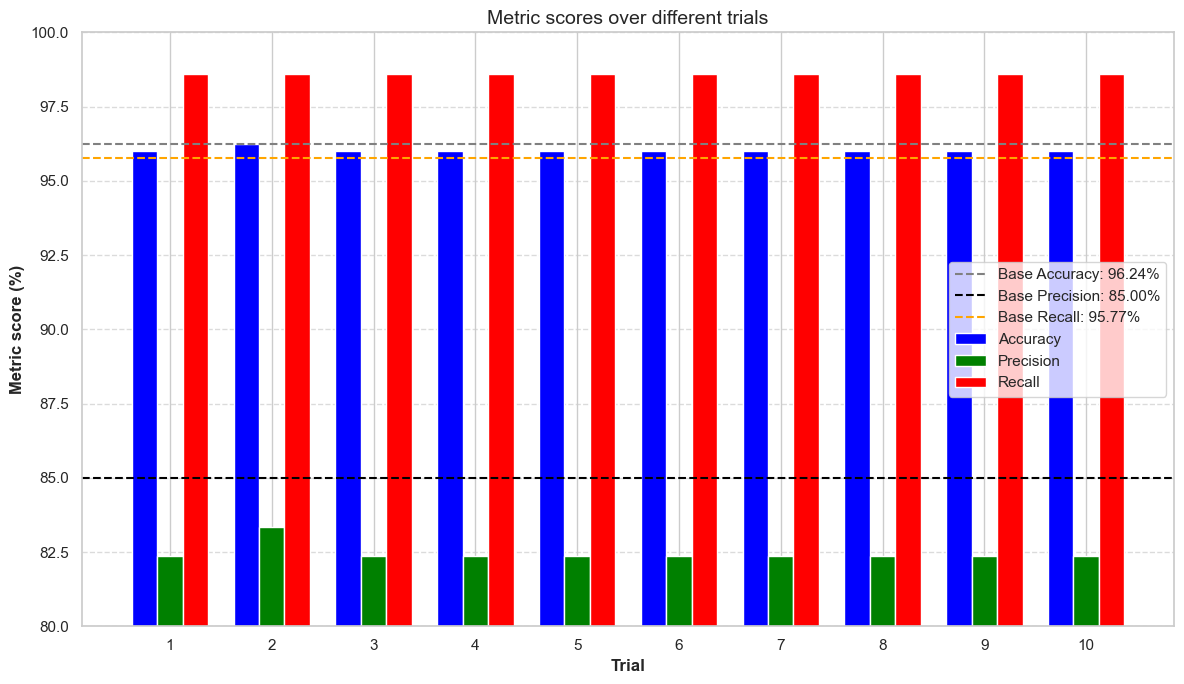

In [97]:
# Now, to plot
sns.set_style('whitegrid')
barWidth = 0.25
fix, ax = plt.subplots(figsize=(12,7))

r1= np.arange(len(seeds))
r2 = [x+barWidth for x in r1]
r3 = [x+barWidth for x in r2]

ax.bar(r1, [x * 100 for x in strat_accs], width=barWidth, label='Accuracy', color='blue')
ax.bar(r2, [x * 100 for x in strat_precs], width=barWidth, label='Precision', color='green')
ax.bar(r3, [x * 100 for x in strat_recs], width=barWidth, label='Recall', color='red')

# Add horizontal lines for base values (Accuracy, Precision, Recall) (multiplying by 100 for percentage representation)
plt.axhline(base_accuracy*100, color='grey', linestyle='--', label=f'Base Accuracy: {base_accuracy*100:.2f}%')
plt.axhline(base_precision*100, color='black', linestyle='--', label=f'Base Precision: {base_precision*100:.2f}%')
plt.axhline(base_recall*100, color='orange', linestyle='--', label=f'Base Recall: {base_recall*100:.2f}%')

ax.set_xlabel('Trial', fontweight='bold', fontsize=12)
ax.set_ylabel('Metric score (%)', fontweight='bold', fontsize=12)
ax.set_title('Metric scores over different trials', fontsize=14)
ax.set_xticks([r+barWidth for r in range(len(seeds))])
ax.set_xticklabels([i+1 for i in range(len(seeds))])
ax.set_ylim(80, 100)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

ax.legend()

plt.tight_layout()
plt.savefig('metrics_different_trials_strat_random.png', dpi=300)
plt.show()



In [106]:
print(set(strat_accs))
print(set(strat_precs))
print(set(strat_recs))

# Determine the index at which the best confidence boundary has better performance than the baseline
base_a = 0
base_p = 0
base_r = 0
best_strat_index = -1

above_base = []
for i in range(len(seeds)):
    if (accuracies[i] > base_a) and (precisions[i] > base_p) and (recalls[i] > base_r):
        above_base.append(i)
        

print(above_base)
print(strat_accs)
print(strat_precs)
print(strat_recs)
above_base = sorted(above_base, key=lambda x: strat_accs[x] + strat_precs[x] + strat_recs[x], reverse=True)
print(above_base)
best_strat_index = above_base[0]
print(best_strat_index)

{0.9598997493734336, 0.9624060150375939}
{0.8235294117647058, 0.8333333333333334}
{0.9859154929577465}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.9598997493734336, 0.9624060150375939, 0.9598997493734336, 0.9598997493734336, 0.9598997493734336, 0.9598997493734336, 0.9598997493734336, 0.9598997493734336, 0.9598997493734336, 0.9598997493734336]
[0.8235294117647058, 0.8333333333333334, 0.8235294117647058, 0.8235294117647058, 0.8235294117647058, 0.8235294117647058, 0.8235294117647058, 0.8235294117647058, 0.8235294117647058, 0.8235294117647058]
[0.9859154929577465, 0.9859154929577465, 0.9859154929577465, 0.9859154929577465, 0.9859154929577465, 0.9859154929577465, 0.9859154929577465, 0.9859154929577465, 0.9859154929577465, 0.9859154929577465]
[1, 0, 2, 3, 4, 5, 6, 7, 8, 9]
1


In [110]:
# Now, to compare the performance of the three options so far: fully labelling unlabelled data and integrating into model, 
# Training on high confidence, and iterative update
print(base_accuracy, base_precision, base_recall)
conc_metrics = {
    'accuracy': accuracy_score(valid_df['ScamClassLabel'], conc_pred),
    'precision': precision_score(valid_df['ScamClassLabel'], conc_pred),
    'recall' : recall_score(valid_df['ScamClassLabel'], conc_pred)
}


# Choose the best element in which all metrics are above the baseline

confidence_bound_metrics = {
    'accuracy': accuracies[best_index],
    'precision': precisions[best_index],
    'recall' : recalls[best_index],
    'confidence_boundary' : confidence_boundaries[best_index]
}

print(confidence_bound_metrics['accuracy'], confidence_bound_metrics['precision'], confidence_bound_metrics['recall'], confidence_bound_metrics['confidence_boundary'])


iterative_metrics = {
    'accuracy' : strat_accs[best_strat_index],
    'precision' : strat_precs[best_strat_index],
    'recall' : strat_recs[best_strat_index]
}

print(iterative_metrics['accuracy'], iterative_metrics['precision'],iterative_metrics['recall'])

0.9624060150375939 0.85 0.9577464788732394
0.9649122807017544 0.8518518518518519 0.971830985915493 0.0011721022975334804
0.9624060150375939 0.8333333333333334 0.9859154929577465


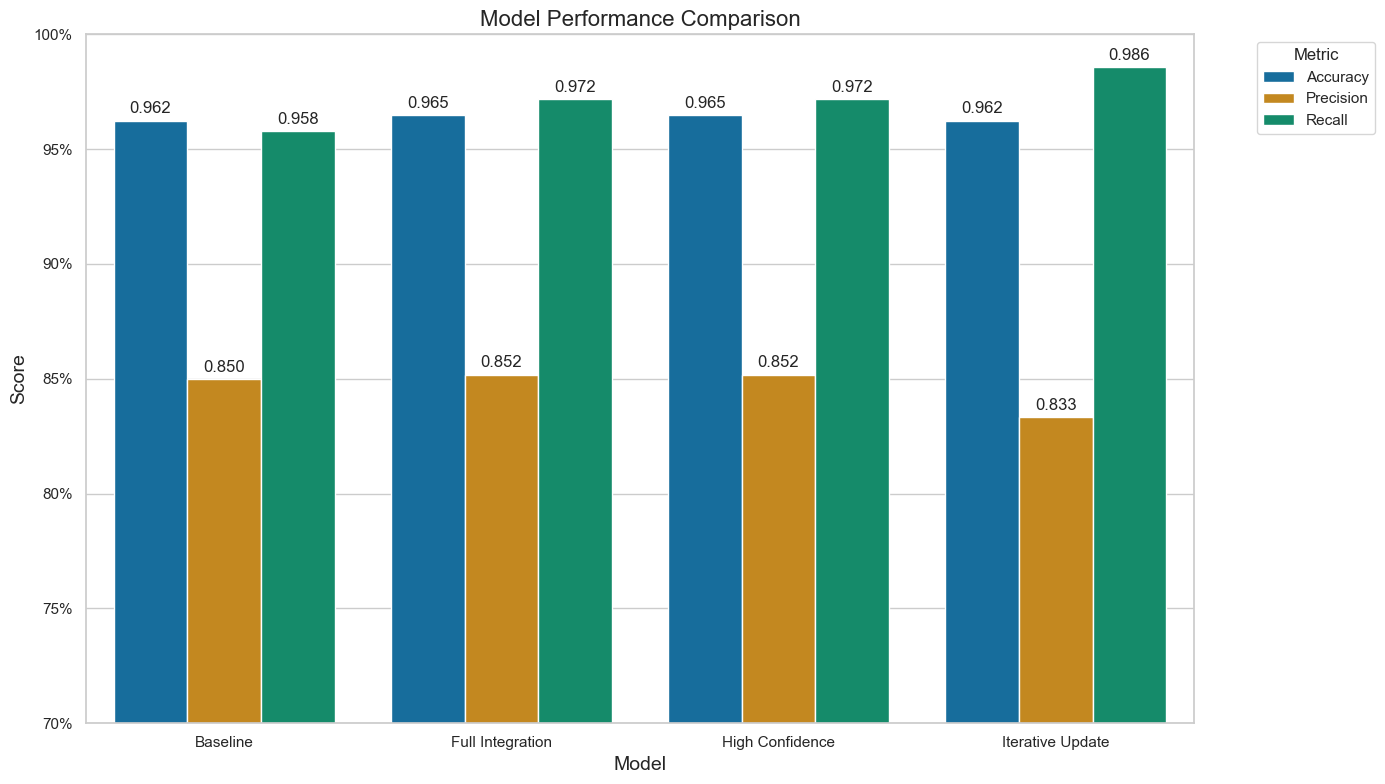

In [111]:
# Create a dataframe for the metrics
models = ['Baseline', 'Full Integration', 'High Confidence', 'Iterative Update']
metrics = ['Accuracy', 'Precision', 'Recall']

# Collect all metrics in a format suitable for seaborn
data = []

# Add baseline metrics
data.append(['Baseline', 'Accuracy', base_accuracy])
data.append(['Baseline', 'Precision', base_precision])
data.append(['Baseline', 'Recall', base_recall])

# Add full integration metrics (conc_metrics)
data.append(['Full Integration', 'Accuracy', conc_metrics['accuracy']])
data.append(['Full Integration', 'Precision', conc_metrics['precision']])
data.append(['Full Integration', 'Recall', conc_metrics['recall']])

# Add high confidence metrics
data.append(['High Confidence', 'Accuracy', confidence_bound_metrics['accuracy']])
data.append(['High Confidence', 'Precision', confidence_bound_metrics['precision']])
data.append(['High Confidence', 'Recall', confidence_bound_metrics['recall']])

# Add iterative update metrics
data.append(['Iterative Update', 'Accuracy', iterative_metrics['accuracy']])
data.append(['Iterative Update', 'Precision', iterative_metrics['precision']])
data.append(['Iterative Update', 'Recall', iterative_metrics['recall']])

# Create DataFrame
df = pd.DataFrame(data, columns=['Model', 'Metric', 'Value'])

# Set up the figure
plt.figure(figsize=(14, 8))

# Create the grouped bar chart with reversed x and hue
sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")  # Use a colorblind-friendly palette

# Plot with seaborn - now x=Model and hue=Metric
ax = sns.barplot(x='Model', y='Value', hue='Metric', data=df)

# Customize the plot
plt.title('Model Performance Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)

# Format y-axis as percentage
ax.set_ylim(0.7, 1.0)  # Adjust as needed based on your actual values
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

# Adjust legend position and title
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for labels
plt.tight_layout()

# Save the figure
plt.savefig('model_metrics_comparison_by_model.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [112]:
# In this case, we'll go with iterative update. 

word_df['ScamClassLabel'].value_counts()

# There is a lot less positive values (scam) than non-positive (non-scam), so precision is less valuable and recall is more important
# We want to catch as many scams as possible, even if some may be non-scams, as it is better to err on caution's side

# Iterative update has the best recall, about equal accuracy but worse precision.


0    1595
1     400
Name: ScamClassLabel, dtype: int64

## 4. Supervised model evaluation